# Region-scale glacier analysis


The previous notebook demonstrated using xarray to analyze surface velocity data for an individual glacier. This notebook will show how we can examine spatial variability in surface velocity within a group of glaciers. To do this we will use xarray as well as **geopandas** and **geocube**.

In [66]:
import os
import json
import urllib.request
import numpy as np
import xarray as xr
import rioxarray as rxr
import geopandas as gpd
import pandas as pd
import seaborn as sns 

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

from shapely.geometry import Polygon
from shapely.geometry import Point
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy
import cartopy.feature as cfeature

from geocube.api.core import make_geocube

%config InlineBackend.figure_format='retina'

In [67]:
import itslivetools

## Accessing ITS_LIVE data

In [68]:
with urllib.request.urlopen('https://its-live-data.s3.amazonaws.com/datacubes/catalog_v02.json') as url_catalog:
    itslive_catalog = json.loads(url_catalog.read().decode())
itslive_catalog.keys()

dict_keys(['type', 'features'])

In [69]:
url = itslivetools.find_granule_by_point(itslive_catalog, [84.56, 28.54])
url

['http://its-live-data.s3.amazonaws.com/datacubes/v02/N20E080/ITS_LIVE_vel_EPSG32645_G0120_X250000_Y3150000.zarr']

In [70]:
dc = itslivetools.read_in_s3(url[0])
dc

<xarray.Dataset>
Dimensions:                    (mid_date: 20549, y: 833, x: 833)
Coordinates:
  * mid_date                   (mid_date) datetime64[ns] 2020-02-07T17:10:52....
  * x                          (x) float64 2.001e+05 2.002e+05 ... 2.999e+05
  * y                          (y) float64 3.2e+06 3.2e+06 ... 3.1e+06 3.1e+06
Data variables: (12/54)
    acquisition_date_img1      (mid_date) datetime64[ns] dask.array<chunksize=(20549,), meta=np.ndarray>
    acquisition_date_img2      (mid_date) datetime64[ns] dask.array<chunksize=(20549,), meta=np.ndarray>
    autoRIFT_software_version  (mid_date) <U5 dask.array<chunksize=(20549,), meta=np.ndarray>
    chip_size_height           (mid_date, y, x) float32 dask.array<chunksize=(20549, 40, 40), meta=np.ndarray>
    chip_size_width            (mid_date, y, x) float32 dask.array<chunksize=(20549, 40, 40), meta=np.ndarray>
    date_center                (mid_date) datetime64[ns] dask.array<chunksize=(20549,), meta=np.ndarray>
    ...                         ...
    vy_error_mask              (mid_date) float64 dask.array<chunksize=(20549,), meta=np.ndarray>
    vy_error_modeled           (mid_date) float64 dask.array<chunksize=(20549,), meta=np.ndarray>
    vy_error_slow              (mid_date) float64 dask.array<chunksize=(20549,), meta=np.ndarray>
    vy_stable_shift            (mid_date) float64 dask.array<chunksize=(20549,), meta=np.ndarray>
    vy_stable_shift_mask       (mid_date) float64 dask.array<chunksize=(20549,), meta=np.ndarray>
    vy_stable_shift_slow       (mid_date) float64 dask.array<chunksize=(20549,), meta=np.ndarray>
Attributes: (12/18)
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               09-Jun-2022 04:14:40
    date_updated:               09-Jun-2022 04:14:40
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v02/N20E080/ITS_...
    skipped_granules:           s3://its-live-data/datacubes/v02/N20E080/ITS_...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image_pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

The `mid_date` dimension of the `dc` object isn't in chronlogical order, so let's sort by this dimension:

In [71]:
dc = dc.sortby('mid_date')

/Users/emarshall/miniconda3/envs/itslivetools_env/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/Users/emarshall/miniconda3/envs/itslivetools_env/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[in

In [73]:
dc

<xarray.Dataset>
Dimensions:                    (mid_date: 20549, y: 833, x: 833)
Coordinates:
  * mid_date                   (mid_date) datetime64[ns] 2013-04-09T16:49:00....
  * x                          (x) float64 2.001e+05 2.002e+05 ... 2.999e+05
  * y                          (y) float64 3.2e+06 3.2e+06 ... 3.1e+06 3.1e+06
Data variables: (12/54)
    acquisition_date_img1      (mid_date) datetime64[ns] dask.array<chunksize=(20549,), meta=np.ndarray>
    acquisition_date_img2      (mid_date) datetime64[ns] dask.array<chunksize=(20549,), meta=np.ndarray>
    autoRIFT_software_version  (mid_date) <U5 dask.array<chunksize=(20549,), meta=np.ndarray>
    chip_size_height           (mid_date, y, x) float32 dask.array<chunksize=(20549, 40, 40), meta=np.ndarray>
    chip_size_width            (mid_date, y, x) float32 dask.array<chunksize=(20549, 40, 40), meta=np.ndarray>
    date_center                (mid_date) datetime64[ns] dask.array<chunksize=(20549,), meta=np.ndarray>
    ...                         ...
    vy_error_mask              (mid_date) float64 dask.array<chunksize=(20549,), meta=np.ndarray>
    vy_error_modeled           (mid_date) float64 dask.array<chunksize=(20549,), meta=np.ndarray>
    vy_error_slow              (mid_date) float64 dask.array<chunksize=(20549,), meta=np.ndarray>
    vy_stable_shift            (mid_date) float64 dask.array<chunksize=(20549,), meta=np.ndarray>
    vy_stable_shift_mask       (mid_date) float64 dask.array<chunksize=(20549,), meta=np.ndarray>
    vy_stable_shift_slow       (mid_date) float64 dask.array<chunksize=(20549,), meta=np.ndarray>
Attributes: (12/18)
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               09-Jun-2022 04:14:40
    date_updated:               09-Jun-2022 04:14:40
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v02/N20E080/ITS_...
    skipped_granules:           s3://its-live-data/datacubes/v02/N20E080/ITS_...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image_pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

## Vector data 

In [74]:
se_asia = gpd.read_file('/Users/emarshall/Desktop/siparcs/data/nsidc0770_15.rgi60.SouthAsiaEast/15_rgi60_SouthAsiaEast.shp')
se_asia.head(3)

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Aspect,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry
0,RGI60-15.00001,G102044E29941N,19990920,-9999999,102.044042,29.941000,15,3,0.438,4996,...,251,850,0,0,0,0,9,9,None,"POLYGON ((102.03759 29.93828, 102.03759 29.938..."
1,RGI60-15.00002,G102042E29987N,19990920,-9999999,102.042346,29.987019,15,3,0.644,4947,...,244,1021,0,0,0,0,9,9,None,"POLYGON ((102.04195 29.99030, 102.04197 29.990..."
2,RGI60-15.00003,G102041E29997N,19990920,-9999999,102.041130,29.997311,15,3,0.225,5019,...,274,812,0,0,0,0,9,9,None,"POLYGON ((102.03710 29.99774, 102.03719 29.998..."


How many glaciers are in this dataframe?

In [75]:
len(se_asia['RGIId'])

13119

What coordinate reference system is this dataframe in? 

In [76]:
se_asia.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

The vector dataset is in WGS 84, meaning that its coordinates are in degrees latitude and longitude rather than meters N and E. We will project this dataset to match the projection of the netcdf dataset.

## Handling projections

Let's project this dataframe to match the CRS of the itslive dataset

In [77]:
#project rgi data to match itslive
se_asia_prj = se_asia.to_crs('EPSG:32645') #we know the epsg from looking at the 'spatial epsg' attr of the mapping var of the dc object
se_asia_prj.head(3)

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Aspect,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry
0,RGI60-15.00001,G102044E29941N,19990920,-9999999,102.044042,29.941000,15,3,0.438,4996,...,251,850,0,0,0,0,9,9,None,"POLYGON ((1959630.570 3408951.748, 1959630.394..."
1,RGI60-15.00002,G102042E29987N,19990920,-9999999,102.042346,29.987019,15,3,0.644,4947,...,244,1021,0,0,0,0,9,9,None,"POLYGON ((1959271.126 3414873.173, 1959273.308..."
2,RGI60-15.00003,G102041E29997N,19990920,-9999999,102.041130,29.997311,15,3,0.225,5019,...,274,812,0,0,0,0,9,9,None,"POLYGON ((1958682.136 3415647.929, 1958684.710..."


Give each glacier (row) a unique integer key that is related to that glacier's RGIId. We will use this later. Be careful that the `RGI_int` column is composed of **integers** not strings.

In [79]:
se_asia_prj['RGI_int'] = se_asia_prj['RGIId'].str.slice(9,).replace('.','_')
se_asia_prj['RGI_int'] = se_asia_prj.RGI_int.apply(lambda x: int('15' + x))
se_asia_prj.RGI_int.dtype

dtype('int64')

To start with, we will look only at glaciers larger in area than 5km2. Subset the dataset to select for those glaciers

In [80]:
se_asia_prj = se_asia_prj.loc[se_asia_prj['Area'] > 5.]
se_asia_prj.head()

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry,RGI_int
185,RGI60-15.00186,G099434E30654N,20020113,-9999999,99.433808,30.653638,15,3,7.214,4802,...,4777,0,0,0,0,9,9,None,"POLYGON ((1695874.226 3459798.452, 1695912.482...",1500186
233,RGI60-15.00234,G097476E28353N,20000927,-9999999,97.475654,28.352548,15,3,8.507,4372,...,5000,0,0,0,0,9,9,None,"POLYGON ((1530972.986 3179732.967, 1530916.956...",1500234
367,RGI60-15.00368,G098674E28425N,20011203,-9999999,98.674072,28.425392,15,3,8.219,3165,...,8634,0,0,0,0,9,9,None,"POLYGON ((1649734.256 3201594.805, 1649822.535...",1500368
405,RGI60-15.00406,G098182E28652N,20011203,-9999999,98.181747,28.651985,15,3,7.800,4544,...,5205,0,0,0,0,9,9,None,"POLYGON ((1599037.782 3218762.806, 1599005.727...",1500406
502,RGI60-15.00503,G098653E28454N,20011203,-9999999,98.652981,28.453739,15,3,7.006,3917,...,9013,0,0,0,0,9,9,None,"POLYGON ((1646656.890 3205777.105, 1646650.233...",1500503


Next, want to subset the RGI dataset by the spatial extent of the ITS_LIVE data.
First, get the bbox of the ITS_LIVE data as a vector

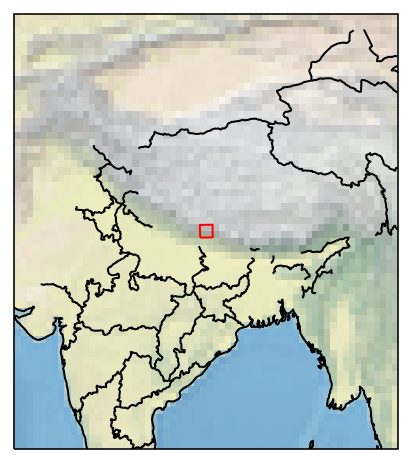

In [81]:
dc_bbox = itslivetools.get_bbox_single(dc)

Project it to local UTM to match the RGI geodataframe and extract the coordinate values from the geometry column

In [82]:
dc_bbox_prj = dc_bbox.to_crs('EPSG:32645')


Subset RGI dataset:

In [83]:
rgi_sub = gpd.sjoin(se_asia_prj, dc_bbox_prj, how='inner')
# need to set the type as string here bc for some reason its object intead of str
rgi_sub["RGIId"] = rgi_sub.RGIId.astype("string")
rgi_sub.head()

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry,RGI_int,index_right
3985,RGI60-15.03986,G084658E28388N,20001122,-9999999,84.658000,28.388000,15,1,5.293,4717,...,0,0,0,0,9,9,None,"POLYGON ((271570.589 3140884.828, 271590.430 3...",1503986,0
4059,RGI60-15.04060,G084967E28552N,20011024,-9999999,84.967453,28.552441,15,1,8.385,3745,...,0,0,0,0,9,9,None,"POLYGON ((301405.276 3159022.291, 301402.929 3...",1504060,0
4069,RGI60-15.04070,G084595E28536N,20011024,-9999999,84.595085,28.535505,15,1,21.036,3929,...,0,0,0,0,9,9,None,"POLYGON ((262651.200 3160204.011, 262651.200 3...",1504070,0
4070,RGI60-15.04071,G084640E28489N,20011024,-9999999,84.639922,28.489260,15,1,17.016,3545,...,0,0,0,0,9,9,None,"POLYGON ((273905.824 3154913.571, 273905.824 3...",1504071,0
4097,RGI60-15.04098,G084588E28582N,20011024,-9999999,84.587667,28.581596,15,1,10.159,3972,...,0,0,0,0,9,9,None,"POLYGON ((264128.109 3165546.243, 264131.022 3...",1504098,0


In [84]:
rgi_sub['RGIId'].values

<StringArray>
['RGI60-15.03986', 'RGI60-15.04060', 'RGI60-15.04070', 'RGI60-15.04071',
 'RGI60-15.04098', 'RGI60-15.04100', 'RGI60-15.04101', 'RGI60-15.04118',
 'RGI60-15.04137', 'RGI60-15.04149', 'RGI60-15.04151', 'RGI60-15.04474',
 'RGI60-15.04515', 'RGI60-15.04541', 'RGI60-15.04600', 'RGI60-15.04611',
 'RGI60-15.04631', 'RGI60-15.04653', 'RGI60-15.04676', 'RGI60-15.04679',
 'RGI60-15.04714', 'RGI60-15.04717', 'RGI60-15.04719', 'RGI60-15.04757',
 'RGI60-15.04766', 'RGI60-15.04768', 'RGI60-15.04813', 'RGI60-15.05140',
 'RGI60-15.09106', 'RGI60-15.10987']
Length: 30, dtype: string

Need to write crs of dc object?

In [85]:
dc = dc.rio.write_crs(f"epsg:{dc.mapping.attrs['spatial_epsg']}", inplace=True)

In [86]:
rgi_sub = rgi_sub.drop('index_right', axis=1)

In [88]:
rgi_sub.head()

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry,RGI_int
3985,RGI60-15.03986,G084658E28388N,20001122,-9999999,84.658000,28.388000,15,1,5.293,4717,...,4231,0,0,0,0,9,9,None,"POLYGON ((271570.589 3140884.828, 271590.430 3...",1503986
4059,RGI60-15.04060,G084967E28552N,20011024,-9999999,84.967453,28.552441,15,1,8.385,3745,...,7788,0,0,0,0,9,9,None,"POLYGON ((301405.276 3159022.291, 301402.929 3...",1504060
4069,RGI60-15.04070,G084595E28536N,20011024,-9999999,84.595085,28.535505,15,1,21.036,3929,...,9643,0,0,0,0,9,9,None,"POLYGON ((262651.200 3160204.011, 262651.200 3...",1504070
4070,RGI60-15.04071,G084640E28489N,20011024,-9999999,84.639922,28.489260,15,1,17.016,3545,...,12793,0,0,0,0,9,9,None,"POLYGON ((273905.824 3154913.571, 273905.824 3...",1504071
4097,RGI60-15.04098,G084588E28582N,20011024,-9999999,84.587667,28.581596,15,1,10.159,3972,...,6536,0,0,0,0,9,9,None,"POLYGON ((264128.109 3165546.243, 264131.022 3...",1504098


Now, use the `make_geocube()` function. This essentially takes a vector object (`rgi_sub`) and rasterizes it, returning an xarray object with the same structure as the object you provide for the `like =` argument (in our case that is `dc`).

In [90]:
out_grid = make_geocube(
    vector_data = rgi_sub,
    measurements = ["RGI_int"],
    like = dc
)
out_grid

<xarray.Dataset>
Dimensions:      (y: 833, x: 833)
Coordinates:
  * y            (y) float64 3.2e+06 3.2e+06 3.2e+06 ... 3.1e+06 3.1e+06 3.1e+06
  * x            (x) float64 2.001e+05 2.002e+05 ... 2.998e+05 2.999e+05
    spatial_ref  int64 0
Data variables:
    RGI_int      (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan

Now each glacier in the geodataframe `rgi_sub` has been coded with a unique integer value that corresponds to that glacier's Randolph Glacier Inventory ID. 

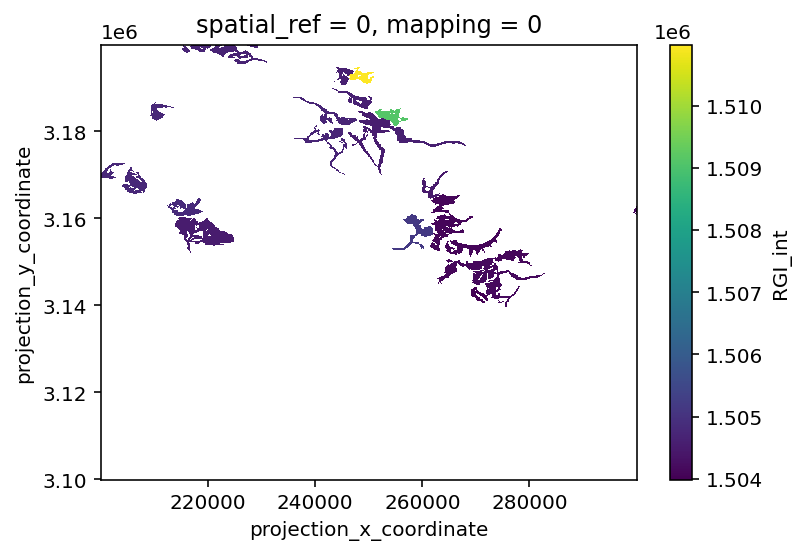

In [92]:
out_grid.RGI_int.plot()

Next, merge the rasterized vector and the dataset containing the velocity data into an xarray dataset:

In [93]:
out_grid['v'] = dc.v 
out_grid

,Array,Chunk
Bytes,53.12 GiB,125.42 MiB
Shape,"(20549, 833, 833)","(20549, 40, 40)"
Count,883 Tasks,441 Chunks
Type,float32,numpy.ndarray


Since we are mostly interested in examining spatial variability, let's take a temporal subset of the dataset to make the computation faster: 

In [95]:
out_grid_sub = out_grid.sel(mid_date = slice('2015-01-01','2015-02-01'))
out_grid_sub

,Array,Chunk
Bytes,195.88 MiB,462.50 kiB
Shape,"(74, 833, 833)","(74, 40, 40)"
Count,1324 Tasks,441 Chunks
Type,float32,numpy.ndarray


In [96]:
grouped_ID = out_grid_sub.drop('spatial_ref').groupby(out_grid_sub['RGI_int'])


In [97]:
#compute zonal stats groupedd by ID
grid_mean_sp = grouped_ID.mean(dim=['mid_date','stacked_y_x']).rename({'v': 'speed_mean'}).compute()
grid_min_sp = grouped_ID.min(dim=['mid_date','stacked_y_x']).rename({'v': 'speed_min'}).compute()
grid_max_sp = grouped_ID.max(dim=['mid_date','stacked_y_x']).rename({'v': 'speed_max'}).compute()
grid_std_sp = grouped_ID.std(dim=['mid_date','stacked_y_x']).rename({'v': 'speed_std'}).compute()
    
#merge each zonal stat xr obj into a single xr obj, convert to pandas df
#zonal_stats = xr.merge([grid_mean_sp, grid_min_sp, grid_max_sp, grid_std_sp]).to_dataframe()
#zonal_stats = zonal_stats.reset_index()
#zonal_stats

Check if the data arrays are equal (the RGI_ints of each should be)

In [102]:
grid_mean_sp.RGI_int.equals([grid_max_sp.RGI_int, grid_min_sp.RGI_int, grid_std_sp.RGI_int])


False

Looks like the issue is with `grid_std_sp`

In [103]:
grid_mean_sp.RGI_int.equals(grid_std_sp.RGI_int)

True

Try to find the differences, ** stuck on this part.... 

or.... could just not use std

In [106]:
#merge each zonal stat xr obj into a single xr obj, convert to pandas df
zonal_stats = xr.merge([grid_mean_sp, grid_min_sp, grid_max_sp]).to_dataframe()
zonal_stats = zonal_stats.reset_index()
zonal_stats = zonal_stats.drop(['mapping','spatial_ref'], axis=1)
zonal_stats

,RGI_int,speed_mean,speed_min,speed_max
0,1503986.0,36.114410,0.0,2038.0
1,1504070.0,66.791031,0.0,4516.0
2,1504071.0,53.550316,0.0,3818.0
3,1504098.0,77.065285,0.0,716.0
4,1504100.0,53.476265,0.0,3686.0
5,1504101.0,50.807049,0.0,2803.0
6,1504118.0,39.886948,0.0,3708.0
7,1504137.0,32.935802,0.0,831.0
8,1504149.0,36.442196,0.0,1602.0
9,1504151.0,60.737225,0.0,5305.0


In [107]:
rgi_itslive = rgi_sub.loc[rgi_sub['Area'] > 5.].merge(zonal_stats, on='RGI_int')


In [115]:
rgi_itslive.columns

Index(['RGIId', 'GLIMSId', 'BgnDate', 'EndDate', 'CenLon', 'CenLat',
       'O1Region', 'O2Region', 'Area', 'Zmin', 'Zmax', 'Zmed', 'Slope',
       'Aspect', 'Lmax', 'Status', 'Connect', 'Form', 'TermType', 'Surging',
       'Linkages', 'Name', 'geometry', 'RGI_int', 'speed_mean', 'speed_min',
       'speed_max'],
      dtype='object')

In [109]:
len(set(rgi_itslive['RGIId']))

29

<AxesSubplot:xlabel='Aspect', ylabel='speed_mean'>

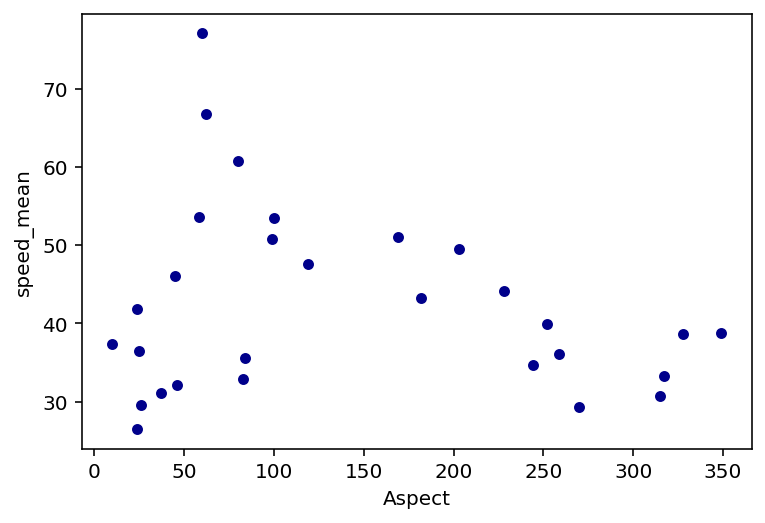

In [116]:
fig, ax = plt.subplots()
rgi_itslive.plot.scatter(x='Aspect',y = 'speed_mean', c = 'darkblue', ax=ax)


<AxesSubplot:>

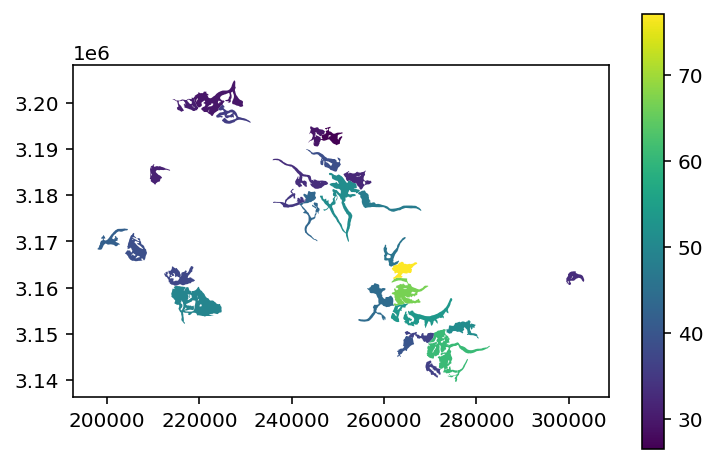

In [114]:
rgi_itslive.plot(column='speed_mean', legend=True)

In [ ]:
rgi_itslive.explore()